In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data
#Get Latest Update Here

https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data

In [21]:
#this prediction only for the death numbers. 

death=pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv")
death.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20
0,Anhui,Mainland China,31.82571,117.2264,0,0,0,0,0,0,...,5,6,6,6,6,6,6,6,6,6
1,Beijing,Mainland China,40.18238,116.4142,0,0,0,0,0,1,...,3,3,4,4,4,4,4,4,4,4
2,Chongqing,Mainland China,30.05718,107.8740,0,0,0,0,0,0,...,4,5,5,5,5,5,5,6,6,6
3,Fujian,Mainland China,26.07783,117.9895,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
4,Gansu,Mainland China,36.06110,103.8343,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2


In [29]:
mainlandChina=death[death['Country/Region']=='Mainland China']
deathByDay=mainlandChina.iloc[:,4:].sum(axis=0, skipna= True)
y=deathByDay.to_numpy('int32')
mainlandChina.tail()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20
26,Tianjin,Mainland China,39.29362,117.33300,0,0,0,0,0,0,...,3,3,3,3,3,3,3,3,3,3
27,Tibet,Mainland China,30.15340,88.78790,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28,Xinjiang,Mainland China,41.11981,85.17822,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,2
29,Yunnan,Mainland China,24.97411,101.48680,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2,2,2
30,Zhejiang,Mainland China,29.18251,120.09850,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1


In [30]:
x=np.arange(len(y))
y2=y.copy()
y2[0:len(y)]=y[0:len(y)]*1.1
##considering underestimate inital death
#print (y2)

In [31]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(x.reshape(-1, 1), y)

/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [32]:
from datetime import datetime

start_date=datetime.strptime('2020-1-22', '%Y-%m-%d')
#start tracking China data from 22 Jan 2020. 

In [33]:
from scipy.optimize import curve_fit
def sigmoid(x, amplitude, x0, k):
    return amplitude * 1.0/(1.0+np.exp(-x0*(x-k)))
popt, pcov = curve_fit(sigmoid, x, y, p0=[1000,0,0])
popt2, pcov2 = curve_fit(sigmoid, x, y2, p0=[1000,0,0])

In [34]:
popt

array([2.93857221e+03, 1.77133310e-01, 2.27258311e+01])

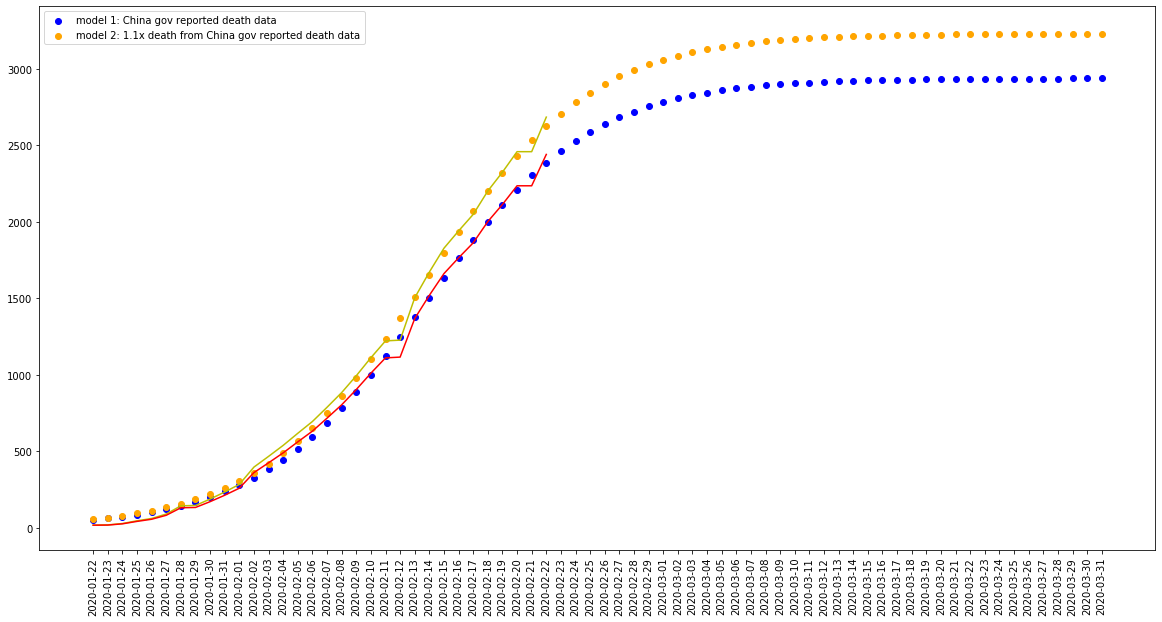

In [35]:
import datetime
plt.figure(figsize=(20,10)) 
plt.scatter(np.arange(70), sigmoid(np.arange(70), *popt),color='blue',label='model 1: China gov reported death data')
plt.scatter(np.arange(70), sigmoid(np.arange(70), *popt2),color='orange',label='model 2: 1.1x death from China gov reported death data')
plt.plot(x, y2,'y-')
plt.plot(x, y,'r-')
plt.legend()
new_tick=[(start_date+datetime.timedelta(days=float(i))).strftime ('%Y-%m-%d') for i in np.arange(70)]
plt.xticks(np.arange(70),
           new_tick
          , rotation=90)
plt.show()


In [15]:
df=pd.DataFrame()
df['data']=new_tick

sigmoid(np.arange(100), *popt)
df['pred death model 1']=sigmoid(np.arange(70), *popt)
df['pred death model 2']=sigmoid(np.arange(70), *popt2)

df['pred death model 1']=df['pred death model 1'].astype('int32')
df['pred death model 2']=df['pred death model 2'].astype('int32')

df['reported death']=0
df['reported death'][0:len(y)]=y
df['daily increase model 1']='NA'
df['daily increase model 1'][0:69]=round(pd.Series([sigmoid(np.arange(70), *popt)[i+1]-sigmoid(np.arange(70), *popt)[i] for i in range(69)]),2)
df['daily increase model 2']='NA'
df['daily increase model 2'][0:69]=round(pd.Series([sigmoid(np.arange(70), *popt2)[i+1]-sigmoid(np.arange(70), *popt2)[i] for i in range(69)]),2)
df['model 1 error']='NA'

df['model 1 error'][0:len(y)]=(sigmoid(np.arange(70), *popt)[0:len(y)]-y).round(2)
df['model 2 error']='NA'
df['model 2 error'][0:len(y)]=(sigmoid(np.arange(70), *popt2)[0:len(y)]-y2).round(2)
df['daily increase model 2 error']='NA'
df['daily increase model 2 error'][0:len(y)]=df['daily increase model 2'][0:len(y)]-round(pd.Series([y[i+1]-y[i] for i in range(len(y)-1)]))


df.to_excel('predictWuhan.xlsx')
df

/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

,data,pred death model 1,pred death model 2,reported death,daily increase model 1,daily increase model 2,model 1 error,model 2 error,daily increase model 2 error
0,2020-01-22,51,56,17,9.78,10.74,34.55,38.58,9.74
1,2020-01-23,61,67,18,11.59,12.73,43.33,48.32,4.73
2,2020-01-24,72,80,26,13.71,15.07,46.92,52.05,-0.93
3,2020-01-25,86,95,42,16.2,17.8,44.63,49.12,3.8
4,2020-01-26,102,112,56,19.1,20.99,46.83,51.92,-5.01
...,...,...,...,...,...,...,...,...,...
65,2020-03-27,2936,3229,0,0.27,0.29,NA,NA,NA
66,2020-03-28,2937,3229,0,0.22,0.24,NA,NA,NA
67,2020-03-29,2937,3229,0,0.19,0.2,NA,NA,NA
68,2020-03-30,2937,3229,0,0.16,0.17,NA,NA,NA


In [16]:
import pandas as pd
x=pd.read_excel('./predictWuhan.xlsx')
x['data']=pd.to_datetime(x['data'],dayfirst=True)
x.sort_values(by=['data'],ascending=True)
x.tail()
x.head()
pd.set_option('display.max_rows', 500)
x

,Unnamed: 0,data,pred death model 1,pred death model 2,reported death,daily increase model 1,daily increase model 2,model 1 error,model 2 error,daily increase model 2 error
0,0,2020-01-22,51,56,17,9.78,10.74,34.55,38.58,9.74
1,1,2020-01-23,61,67,18,11.59,12.73,43.33,48.32,4.73
2,2,2020-01-24,72,80,26,13.71,15.07,46.92,52.05,-0.93
3,3,2020-01-25,86,95,42,16.20,17.80,44.63,49.12,3.80
4,4,2020-01-26,102,112,56,19.10,20.99,46.83,51.92,-5.01
5,5,2020-01-27,121,133,82,22.47,24.69,39.93,43.91,-24.31
6,6,2020-01-28,144,158,131,26.36,28.97,13.40,14.60,26.97
7,7,2020-01-29,170,187,133,30.82,33.88,37.76,41.57,-4.12
8,8,2020-01-30,201,221,171,35.91,39.47,30.58,33.45,-2.53
9,9,2020-01-31,237,260,213,41.65,45.79,24.49,26.92,-0.21
